In [9]:
from tqdm import tqdm
import pickle

from skimage import io, measure
import numpy as np 
import h5py
from brainlit.preprocessing import image_process
from brainlit.algorithms.connect_fragments import dynamic_programming_viterbi2
import scipy.ndimage as ndi 
from sklearn.metrics import pairwise_distances_argmin_min
import napari
import networkx as nx
from napari.utils import nbscreenshot

In [2]:
image = 0.5*np.ones((100,100,1))
image[50:55,0:25,0] = 0.91
image[50:55,30:50,0] = 0.92
image[45:50,55:75,0] = 0.93
image[60:65,55:75,0] = 0.94
image[45:60,85:,0] = 0.95

labels = np.zeros((100,100,1), dtype=int)
labels[50:55,0:25,0] = 1
labels[50:55,30:50,0] = 2
labels[45:50,55:75,0] = 3
labels[60:65,55:75,0] = 4
labels[45:60,85:,0] = 5

axon_coords = [[52, 2, 0]]
soma_coords = [[50, 90, 0]]

res = [0.1,0.1,0.1]

In [3]:
_, axon_lbls = image_process.label_points(labels, axon_coords, res)
axon_lbl= axon_lbls[0]
_, soma_lbls = image_process.label_points(labels, soma_coords, res)
soma_lbl = soma_lbls[0]

In [4]:
mpnp = dynamic_programming_viterbi2.most_probable_neuron_path(image, labels, [soma_lbl], res)
mpnp.frags_to_lines()
mpnp.compute_all_costs_dist(point_point_func = mpnp.point_point_dist, point_blob_func = mpnp.point_blob_dist)
mpnp.compute_all_costs_int()
mpnp.create_nx_graph()

Adding edges to nx graph: 100%|██████████| 9/9 [00:00<00:00, 14239.43it/s]


In [5]:
path_states = nx.shortest_path(mpnp.nxGraph, 0, 8, weight='weight')
path_comps = [mpnp.state_to_comp[state][1] for state in path_states]
print(path_comps)

[1, 2, 3, 5]


path sequence: [0, 2, 4, 8]
component sequence: [1, 2, 3, 5]
Trans. #1: dist cost state 0->state 2, comp 1->comp 2: 0.00, int cost: 138.10, cum. cost: 138.11
Trans. #2: dist cost state 2->state 4, comp 2->comp 3: 0.52, int cost: 138.10, cum. cost: 276.73
Trans. #3: dist cost state 4->state 8, comp 3->comp 5: 0.80, int cost: 71.81, cum. cost: 349.35


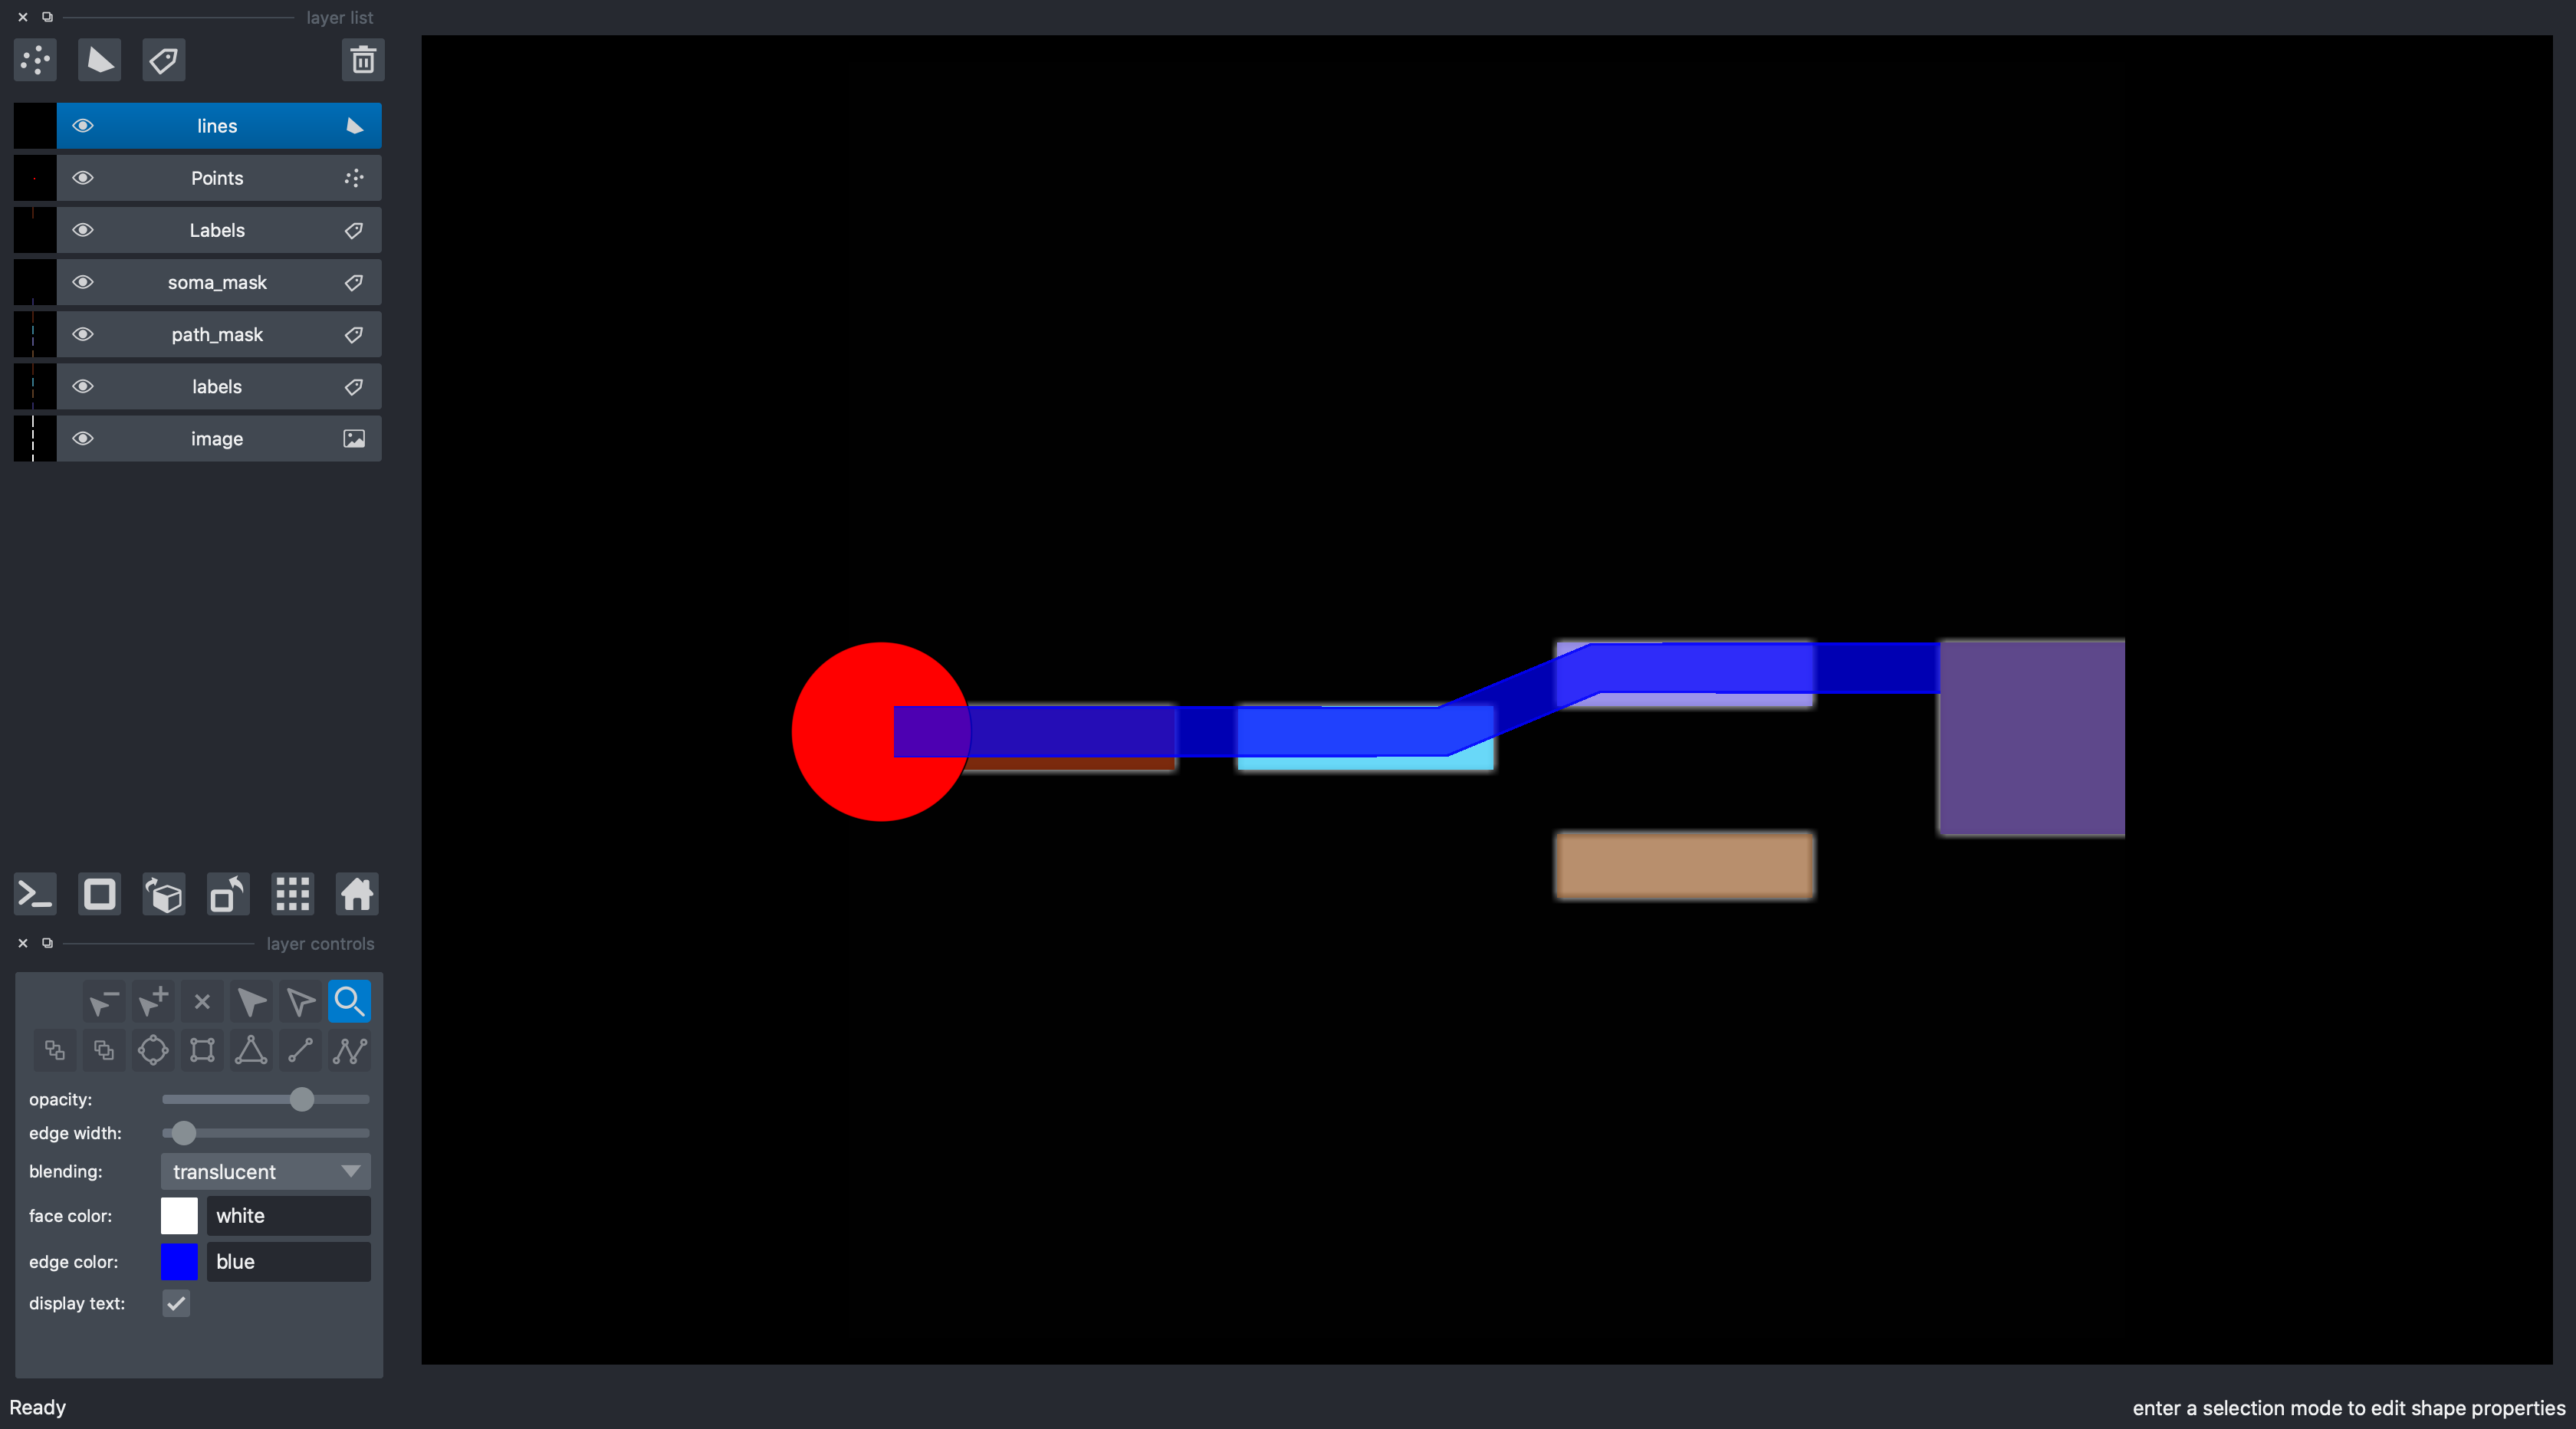

In [10]:
path_comps = []
for state in path_states:
    path_comps.append(mpnp.state_to_comp[state][1])
print(f'path sequence: {path_states}')
print(f'component sequence: {path_comps}')

path_mask = 0*labels
for i, label in enumerate(path_comps):
    path_mask[labels == label] = i+1

soma_mask = 0*labels
for soma_lbl in mpnp.soma_lbls:
    soma_mask[labels == soma_lbl] = soma_lbl

viewer = napari.Viewer(ndisplay=3)
viewer.add_image(mpnp.image)
viewer.add_labels(labels)
viewer.add_labels(path_mask)
viewer.add_labels(soma_mask)
viewer.add_labels(labels == axon_lbl)

viewer.add_points([axon_coords[0]], face_color="red", size=10)

lines = []
cumul_cost = 0
for s, state in enumerate(path_states):
    if s>0:
        dist_cost = mpnp.cost_mat_dist[path_states[s-1], state]
        int_cost = mpnp.cost_mat_int[path_states[s-1], state]
        cumul_cost += dist_cost + int_cost
        print(f"Trans. #{s}: dist cost state {path_states[s-1]}->state {state}, comp {mpnp.state_to_comp[path_states[s-1]][1]}->comp {mpnp.state_to_comp[state][1]}: {dist_cost:.2f}, int cost: {int_cost:.2f}, cum. cost: {cumul_cost:.2f}")
    if mpnp.state_to_comp[state][0] == "fragment":
        lines.append(list(mpnp.state_to_comp[state][2]["coord1"]))
        lines.append(list(mpnp.state_to_comp[state][2]["coord2"]))
    elif mpnp.state_to_comp[path_states[s-1]][0] == "fragment":
        lines.append(list(mpnp.state_to_comp[path_states[s-1]][2]["soma connection point"]))     
viewer.add_shapes(lines, shape_type="path", edge_color="blue", edge_width=2)

viewer.camera.angles = [0, -90, 180]
nbscreenshot(viewer)
